refs: https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

In [2]:
import uproot
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt

from reco.plotting import plot_event, plot_remapped, plot_tracksters
from reco.evaluation import evaluate, evaluate_remapped
from reco.event import remap_arrays_by_label, remap_items_by_label
from reco.energy import get_total_energy
%matplotlib inline

# file_name = "~/Data/pions/new_ntuples_14955802_7.root"
file_name = "~/Data/multi/new_ntuples_14992862_996.root"


tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})

Tracksters reco: 123, tracksters sim: 10
Simulated energy: 3423.19, reconstructed energy: 2886.56 (84.32%)


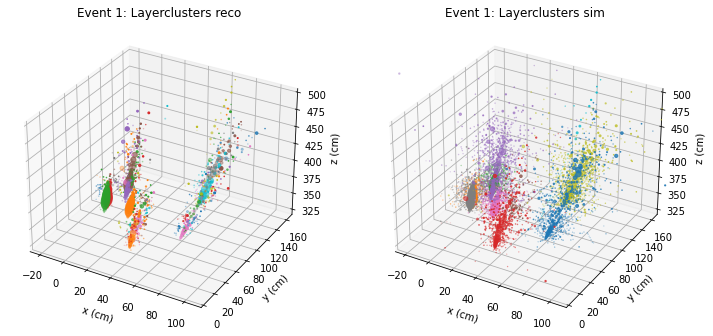

In [3]:
eid = 1

t_indexes = tracksters["vertices_indexes"].array()[eid]
t_energy = tracksters["vertices_energy"].array()[eid]
v_multi = tracksters["vertices_multiplicity"].array()[eid]
st_indexes = simtracksters["stsSC_vertices_indexes"].array()[eid]
st_energy = simtracksters["stsSC_vertices_energy"].array()[eid]
sv_multi = simtracksters["stsSC_vertices_multiplicity"].array()[eid]

print(f"Tracksters reco: {len(t_indexes)}, tracksters sim: {len(st_indexes)}")

reco_total = get_total_energy(t_energy, v_multi)
sim_total = get_total_energy(st_energy, sv_multi)
print(f"Simulated energy: {sim_total:.2f}, reconstructed energy: {reco_total:.2f} ({(reco_total / sim_total) * 100:.2f}%)")

plot_event(tracksters, simtracksters, eid, legend=False)

In [4]:
precision, recall, fscore = evaluate(t_indexes, st_indexes, t_energy, st_energy, v_multi, sv_multi, noise=False)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

Precision: 0.97, Recall: 0.16, F-score: 0.28


In [5]:
x_bary = tracksters["barycenter_x"].array()[eid]
y_bary = tracksters["barycenter_y"].array()[eid]
z_bary = tracksters["barycenter_z"].array()[eid]
X = np.array([x_bary, y_bary, z_bary]).T

# this is not an entirely fair comparison:
# the LC level methods should use sim LCs not only the CLUE3D ones
# using sim data here is possible, but gets complicated
x_lc = ak.flatten(tracksters["vertices_x"].array()[eid])
y_lc = ak.flatten(tracksters["vertices_y"].array()[eid])
z_lc = ak.flatten(tracksters["vertices_z"].array()[eid])
X_vertices = np.array([x_lc, y_lc, z_lc]).T

## k-means

Apply k-means algorithm on CLUE3D barycentres and on layerclusters

In [6]:
from sklearn.cluster import KMeans

Precision: 0.81, Recall: 0.68, F-score: 0.74


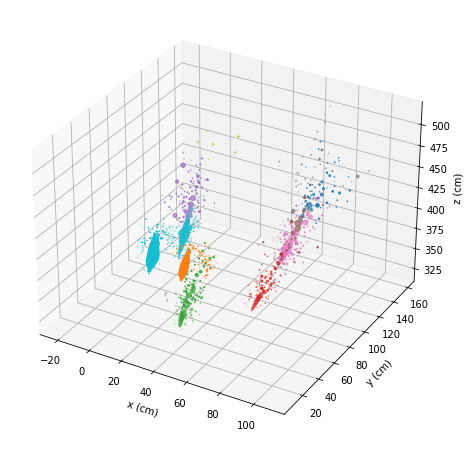

In [7]:
# kmeans on barycentres
K = len(st_indexes)
kmeans = KMeans(n_clusters=K, random_state=0).fit(X)
evaluate_remapped(t_indexes, st_indexes, t_energy, st_energy, v_multi, sv_multi, kmeans.labels_)
plot_remapped(tracksters, eid, kmeans.labels_)

Precision: 0.78, Recall: 0.62, F-score: 0.69


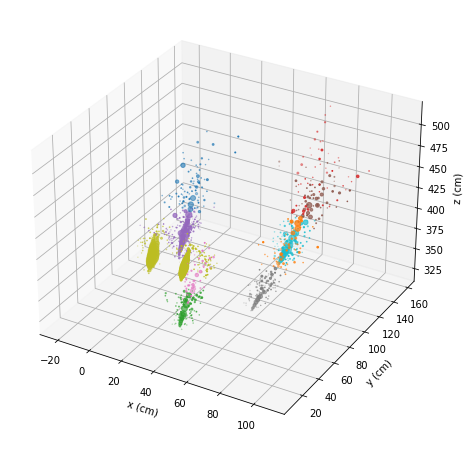

In [8]:
# kmeans on layerclusters
K = len(st_indexes)
kmeans = KMeans(n_clusters=K, random_state=0).fit(X_vertices)

ri = remap_items_by_label(ak.flatten(t_indexes), kmeans.labels_)
re = remap_items_by_label(ak.flatten(t_energy), kmeans.labels_)
rm = remap_items_by_label(ak.flatten(v_multi), kmeans.labels_)

precision, recall, fscore = evaluate(ri, st_indexes, re, st_energy, rm, sv_multi, noise=False)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

rx = remap_items_by_label(ak.flatten(tracksters["vertices_x"].array()[eid]), kmeans.labels_)
ry = remap_items_by_label(ak.flatten(tracksters["vertices_y"].array()[eid]), kmeans.labels_)
rz = remap_items_by_label(ak.flatten(tracksters["vertices_z"].array()[eid]), kmeans.labels_)
re = remap_items_by_label(ak.flatten(tracksters["vertices_energy"].array()[eid]), kmeans.labels_)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
plot_tracksters(ax, rx, ry, rz, re)
plt.show()

## GMM

Apply Gaussian Mixture Models on barycentres and layerclusters

In [36]:
from sklearn.mixture import GaussianMixture
K = len(st_indexes)

Precision: 0.75, Recall: 0.67, F-score: 0.71


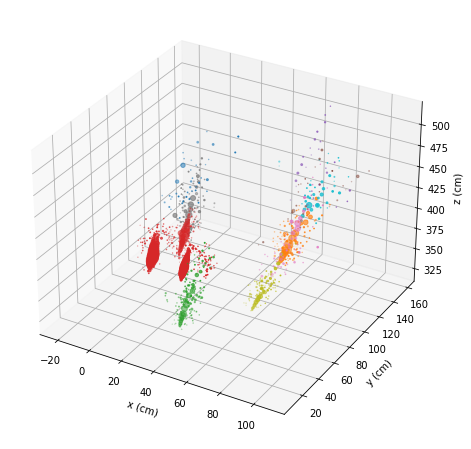

In [37]:
# gmm on barycentres
gmm = GaussianMixture(n_components=K, covariance_type='full').fit(X)
gmm_labels = gmm.predict(X)

# gmm.predict_proba(X) - gives multiplicity?
evaluate_remapped(t_indexes, st_indexes, t_energy, st_energy, v_multi, sv_multi, gmm_labels)
plot_remapped(tracksters, eid, gmm_labels)

Precision: 0.86, Recall: 0.58, F-score: 0.69


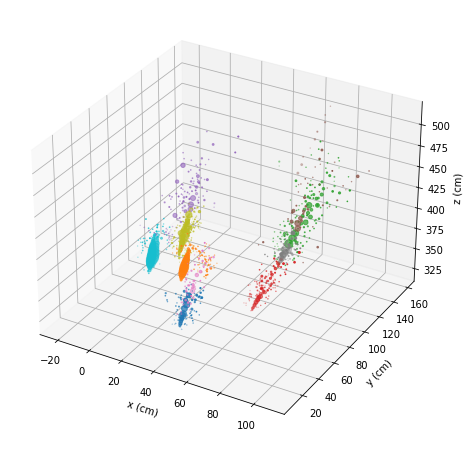

In [38]:
# gmm on layerclusters
gmm = GaussianMixture(n_components=K, covariance_type='full').fit(X_vertices)
gmm_labels = gmm.predict(X_vertices)

ri = remap_items_by_label(ak.flatten(t_indexes), gmm_labels)
re = remap_items_by_label(ak.flatten(t_energy), gmm_labels)
rm = remap_items_by_label(ak.flatten(v_multi), gmm_labels)

precision, recall, fscore = evaluate(ri, st_indexes, re, st_energy, rm, sv_multi, noise=False)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

rx = remap_items_by_label(ak.flatten(tracksters["vertices_x"].array()[eid]), gmm_labels)
ry = remap_items_by_label(ak.flatten(tracksters["vertices_y"].array()[eid]), gmm_labels)
rz = remap_items_by_label(ak.flatten(tracksters["vertices_z"].array()[eid]), gmm_labels)
re = remap_items_by_label(ak.flatten(tracksters["vertices_energy"].array()[eid]), gmm_labels)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
plot_tracksters(ax, rx, ry, rz, re)
plt.show()

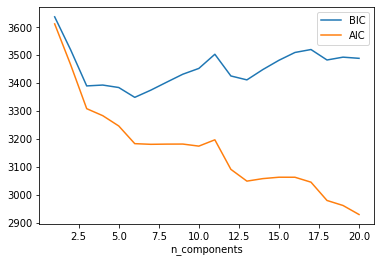

In [39]:
# try to guesstimate the number of components
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X)
          for n in n_components]

plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');